In [1]:
import numpy as np
import os
from os.path import join, isdir, getsize, exists
# from nltk.stem.snowball import SnowballStemmer
import json
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and proprocess documents
**Load document labels**

In [2]:
segmented_path = u'./corpus/segmented-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(segmented_path) if isdir(join(segmented_path, fn))] # list only folders
doc_labels_idx = {}
n_labels = len(doc_labels)
for i, label in enumerate(doc_labels):
    print i, label
    doc_labels_idx[label] = i
print 'Total Labels:', n_labels

0 บริหารธุรกิจ
1 ประมง
2 มนุษยศาสตร์
3 วนศาสตร์
4 วิทยาการจัดการ
5 วิทยาศาสตร์
6 วิทยาศาสตร์การกีฬา
7 วิศวกรรมศาสตร์
8 ศิลปศาสตร์และวิทยาศาสตร์
9 ศึกษาศาสตร์
10 ศึกษาศาสตร์และพัฒนศาสตร์
11 สถาปัตยกรรมศาสตร์
12 สังคมศาสตร์
13 สัตวแพทยศาสตร์
14 สิ่งแวดล้อม
15 อุตสาหกรรมเกษตร
16 เกษตร
17 เศรษฐศาสตร์
18 โครงการจัดตั้งวิทยาเขตสุพรรณบุรี
19 โครงการสหวิทยาการระดับบัณฑิตศึกษา
Total Labels: 20


** Load dataset **

In [3]:
%%time
dataset_contents, dataset_labels = [], []
for i, label in enumerate(doc_labels):
    curr_dir = join(segmented_path, label)
    fns = os.listdir(curr_dir)
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            dataset_contents.append(content)
            dataset_labels.append(i)
N = len(dataset_contents)
print 'Total Segmented Documents:', N

Total Segmented Documents: 2549
Wall time: 1min 15s


**Test English word stemmer from Natural Language Toolkit**

In [8]:
# stemmer = SnowballStemmer('english')
# test_words = u'reply represent representation representative expression cats feeling นำเสนอนะ'.split()
# for word in test_words:
#     print word, stemmer.stem(word)

reply repli
represent repres
representation represent
representative repres
expression express
cats cat
feeling feel
นำเสนอนะ นำเสนอนะ


** Define a function that trims and stems words then replace all PIPELINE by space **

In [4]:
def pretty_trim(text):
    words = text.split(u'|')
    stripped_words_generator = (word.strip() for word in words)
#     stemmed_words_generator = (stemmer.stem(word) for word in stripped_words_generator)
    trimmed_words = (word for word in stripped_words_generator if word) # retains words that are not empty
    return u' '.join(trimmed_words)

**Show sample content**

In [5]:
print 'Content:', dataset_contents[1][:2**9], '...'
print 'Label:', dataset_labels[1]

Content: i|49737869| |i| |page| |I|วิทยานิพนธ์| |P|การ|วิเคราะห์|ต้นทุน|ต่อ|หน่วย|ผลผลิต| |ใน|การผลิต|บัณฑิต|ระดับ|ปริญญาตรี|ของ|วิทยาลัย|เอกชน| |จังหวัด|สุราษฎร์ธานี| |i| |analysi| |of| |cost| |per| |output| |unit| |in| |produc| |undergradu| |iof| |a| |privat| |colleg| |in| |surat| |thani| |prov| |inc| |I|นางสาว|กา|ญ|จน|ธัช| |บัว|พา| |I|บัณฑิต|วิทยาลัย| |มหาวิทยาลัยเกษตรศาสตร์| |I|พ| |ศ| |๒๕๕๔| |I|ใบรับรอง|วิทยานิพนธ์| |I|บัณฑิต|วิทยาลัย| |มหาวิทยาลัยเกษตรศาสตร์| |I|บัญชีมหาบัณฑิต| |I|ปริญญา| |I|บัญชี| |บัญชี| |I|ส ...
Label: 0


** Show sample content after pretty_trimmed() **

In [ ]:
print 'Content:', pretty_trim(dataset_contents[1][:2**9]), '...'
print 'Label Str:', doc_labels[dataset_labels[1]]

Content: i 49737869 i page I วิทยานิพนธ์ P การ วิเคราะห์ ต้นทุน ต่อ หน่วย ผลผลิต ใน การผลิต บัณฑิต ระดับ ปริญญาตรี ของ วิทยาลัย เอกชน จังหวัด สุราษฎร์ธานี i analysi of cost per output unit in produc undergradu iof a privat colleg in surat thani prov inc I นางสาว กา ญ จน ธัช บัว พา I บัณฑิต วิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ I พ ศ ๒๕๕๔ I ใบรับรอง วิทยานิพนธ์ I บัณฑิต วิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ I บัญชีมหาบัณฑิต I ปริญญา I บัญชี บัญชี I ส ...
Label Str: บริหารธุรกิจ


## Trim all documents

In [ ]:
%%time
fp = u'./corpus/dataset_contents_trimmed.json'
if exists(fp):
    print 'Loading trimmed documents ...'
    with open(fp, 'r') as f:
        dataset_contents_trimmed = json.load(f)
else:
    print 'Trimming documents ...'
    dataset_contents_trimmed = map(pretty_trim, dataset_contents)
    print 'Dumping ...'
    # dumb into a big file for later use because this list is very costful to compute
    with open(fp, 'w') as f:
        json.dump(dataset_contents_trimmed, f, ensure_ascii=True)
print 'Size in GB:', getsize(fp) / 1024.0 / 1024.0 / 1024.0

Loading trimmed documents ...


In [ ]:
del dataset_contents

** Count number of words for each document **

In [10]:
%time dataset_words_count = np.array([len(content.split()) for content in dataset_contents_trimmed])
print 'Words Count Mean: ', np.mean(dataset_words_count)
dataset_words_count[:min(40,N)]

Wall time: 12.1 s
Words Count Mean:  42285.5268733


array([45472, 78883, 26280, 45636, 40991, 43624, 51190, 58068, 35827,
       48881, 39265, 55482, 27362, 35126, 34087, 52162, 42342, 38450,
       40987, 34572, 32222, 27636, 28945, 43572, 53255, 54756, 42671,
       29462, 43227, 40838, 53799, 68424, 38497, 48087, 84428, 55090,
       52365, 74338, 60454, 45600])

** Show words count histogram **

<IPython.core.display.Javascript object>


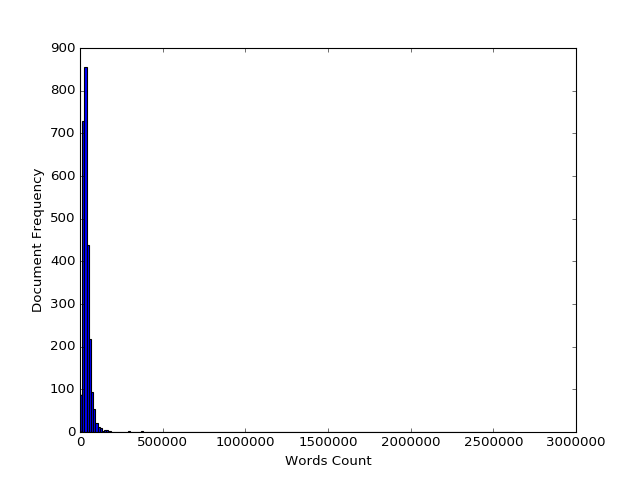

In [11]:
plt.figure()
plt.hist(dataset_words_count, bins=200)
plt.xlabel('Words Count')
plt.ylabel('Document Frequency')
plt.show()

# Machine Learning section

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.neural_network import BernoulliRBM
from collections import Counter
from scipy.sparse import vstack

## Train/Test Split
Split dataset into 2 parts and leave the test part untouched (not fitting it with any model)

Split using stratified sampling might be useful if you want to test all label including the skewed low frequency label

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset_contents_trimmed, np.array(dataset_labels),
                                                    test_size=0.2, stratify=dataset_labels, random_state=42)
print 'Train Size:', len(X_train)
print 'Test Size:', len(X_test)
train_counter, test_counter = Counter(y_train), Counter(y_test)
print 'Un-trained label:', list(set(xrange(n_labels)) - set(train_counter))
print 'Un-tested label:', list(set(xrange(n_labels)) - set(test_counter))

Train Size: 2039
Test Size: 510
Un-trained label: []
Un-tested label: []


### Plot bar chart of dataset frequency per label

<IPython.core.display.Javascript object>


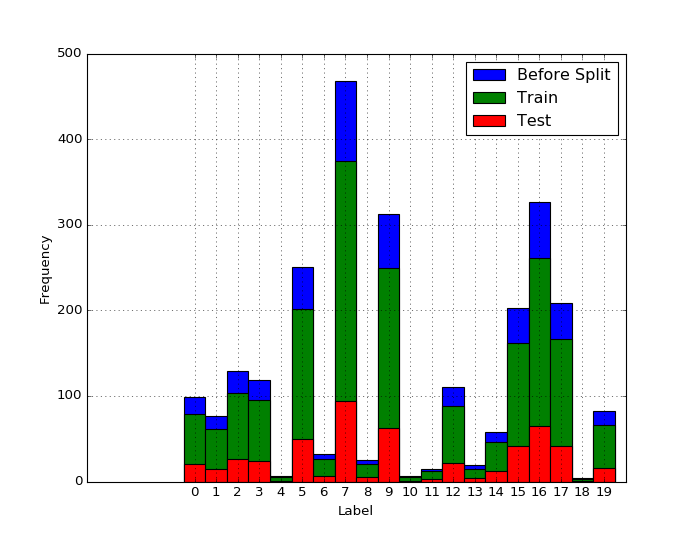

In [14]:
train_label_freqs = np.zeros(n_labels, np.int32)
test_label_freqs = np.zeros(n_labels, np.int32)
dataset_label_freqs = np.zeros(n_labels, np.int32)
for k,v in train_counter.iteritems():
    train_label_freqs[k] = v
for k,v in test_counter.iteritems():
    test_label_freqs[k] = v
for k,v in Counter(dataset_labels).iteritems():
    dataset_label_freqs[k] = v
plt.figure()
plt.bar(np.arange(n_labels)-0.5, dataset_label_freqs, 1, color='b')
plt.bar(np.arange(n_labels)-0.5, train_label_freqs, 1, color='g')
plt.bar(np.arange(n_labels)-0.5, test_label_freqs, 1, color='r')
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend(['Before Split','Train', 'Test'], loc='best')
plt.grid()
plt.show()

## Feature Extraction
### Bag of Words Representation
Initialize a vectorizer that counts word instances and apply Tfidf (Term-Frequency * Inverse-Document-Frequency) to them

In [20]:
## saving English stop words to disk
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# stop_words = ENGLISH_STOP_WORDS
# fp = 'stop_words.txt'
# with open(fp, 'w') as f:
#     words = u'\n'.join(sorted(stop_words))
#     f.write(words.encode('utf-8'))
# print len(stop_words)

318


In [15]:
## reading stop words from disk
fp = 'stop_words_unique.txt'
with open(fp, 'r') as f:
    stop_words = unicode(f.read(), 'utf-8')
stop_words = stop_words.split(u'\n')
print 'Stop Words:', len(stop_words)

Stop Words: 928


In [68]:
%%time
counter = CountVectorizer(encoding=u'utf-8', stop_words=stop_words, ngram_range=(2,2), max_features=100000)
%time X_train_count = counter.fit_transform(X_train)
%time X_test_count = counter.transform(X_test)

tfidf = TfidfTransformer()
%time X_train_vectorized = tfidf.fit_transform(X_train_count)
%time X_test_vectorized = tfidf.transform(X_test_count)

Wall time: 8min 30s


** Save extracted feature names to disk **

In [69]:
%%time
feature_names = counter.get_feature_names()
fn = 'feature_names.txt'
with open(fn, 'w') as f:
    f.write(u'\n'.join(feature_names).encode('utf8'))
print 'Check file %s to see all extracted feature names' % fn
print 'Total names:', len(feature_names)

Check file feature_names.txt to see all extracted feature names
Total names: 7046851
Wall time: 28.6 s
Parser   : 132 ms


**Vectorized Dataset Statistics**

In [70]:
print 'Train Shape:', X_train_vectorized.shape
print 'Sample content of type %s:' % type(X_train_vectorized)
print X_train_vectorized

Train Shape: (2039, 7046851)
Sample content of type <class 'scipy.sparse.csr.csr_matrix'>:
  (0, 4817907)	0.000754345976292
  (0, 5348921)	0.000789311703738
  (0, 5917516)	0.000523387804206
  (0, 5206178)	0.000704078441834
  (0, 6319826)	0.000980435167389
  (0, 5317133)	0.000676040664696
  (0, 4806341)	0.000664000657478
  (0, 4932424)	0.000667891714889
  (0, 4996717)	0.000739848744325
  (0, 4523584)	0.000913853775829
  (0, 5692404)	0.000811085657324
  (0, 5652414)	0.000942938472197
  (0, 5378998)	0.000852593153383
  (0, 4896123)	0.000554112028398
  (0, 5902000)	0.00061373312302
  (0, 5905645)	0.000754345976292
  (0, 4786198)	0.000811085657324
  (0, 6355931)	0.00103328379101
  (0, 5903761)	0.000739848744325
  (0, 6597726)	0.000549254047092
  (0, 3455115)	0.000980435167389
  (0, 3747269)	0.000823508457015
  (0, 1898124)	0.000603701963704
  (0, 3462663)	0.000799744529761
  (0, 5901813)	0.000733163138202
  :	:
  (2038, 6133186)	0.000695082112326
  (2038, 5475674)	0.000949810724127
  (2038,

## Feature Selection

Recursive feature elimination using weights of Linear Kernel Support Vector Machine

In [71]:
%%time
rfe = RFE(SGDClassifier(loss='hinge'), n_features_to_select=20000, step=0.2, verbose=1)
X_train_selected = rfe.fit_transform(X_train_vectorized, y_train)
X_test_selected = rfe.transform(X_test_vectorized)
print X_train_selected.shape, X_test_selected.shape

(2039, 20000) (510, 20000)
Wall time: 3min 21s


** Save top feature names to file **

In [72]:
%%time
top_features = [feature for feature, support in zip(feature_names, rfe.support_) if support]
file_name = 'feature_names_top.txt'
with open(file_name, 'w') as f:
    f.write(u'\n'.join(top_features).encode('utf8'))
print 'Go check file %s' % file_name

Go check file feature_names_top.txt
Wall time: 34.2 s
Parser   : 291 ms


** Save word count to disk **

In [76]:
%%time
X_train_count_support = X_train_count[:,rfe.support_].T
m, n = X_train_count_support.shape[0], len(doc_labels)
freqs = np.empty((m, n), np.int32)

for label in xrange(n):
    freqs[:,label] = X_train_count_support[:,y_train==label].sum(axis=1).flatten()

with open('word_count_per_label.txt', 'w') as f:
    for i in xrange(m):
        line = []
        for j in xrange(n):
            line.append(str(freqs[i,j]))
        f.write('\t'.join(line) + '\n')

print freqs.shape

(20000L, 20L)
Wall time: 11 s


## Dimensionality Reduction

#### Unsupervised non-linear dimension reduction

Pre-training with Bernoulli Restricted Boltzmann Machine

In [91]:
# %%time
# rbm = BernoulliRBM(n_components=50, learning_rate=0.2, batch_size=20, n_iter=20, random_state=42, verbose=1)
# X_train_rbm = rbm.fit_transform(X_train_selected)
# X_test_rbm = rbm.transform(X_test_selected)
# print X_train_rbm.shape

[BernoulliRBM] Iteration 1, pseudo-likelihood = -452.91, time = 8.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -35.33, time = 8.45s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -19.68, time = 8.61s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -16.75, time = 8.38s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -14.76, time = 8.89s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -15.02, time = 9.84s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -14.44, time = 7.73s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -13.56, time = 7.60s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -12.23, time = 7.61s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -12.87, time = 6.79s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -12.21, time = 8.57s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -12.50, time = 9.43s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -12.68, time = 7.47s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -12.86, time = 10.05s
[BernoulliRBM] Iteration 15

In [92]:
# print rbm.components_.shape
# print rbm.components_ # weight of each edge, components_[i,j] = weight of edge from hidden node i to visible node j

(50L, 20000L)
[[-0.03572855 -0.05813121 -0.0562077  ..., -0.13155343 -0.07418611
  -0.14079532]
 [-0.03441731 -0.02968999 -0.05920262 ..., -0.09267987 -0.06091394
  -0.10048683]
 [-0.04704162 -0.04297848 -0.06149489 ..., -0.1244551  -0.11109585
  -0.12007697]
 ..., 
 [-0.01286344 -0.03939054 -0.05986788 ..., -0.10667528 -0.06860802
  -0.1033964 ]
 [-0.04138484 -0.05222536 -0.05048636 ..., -0.12131422 -0.07424998
  -0.1004438 ]
 [-0.04486198 -0.02612365 -0.04348389 ..., -0.10224552 -0.0587047
  -0.10635221]]


Truncated SVD (Single Value Decomposition) is called Latent Semantic Analysis (LSA) in text analysis context

In [345]:
# %%time
# svd = TruncatedSVD(n_components=200) # works on sparse data
# X_train_reduced = svd.fit_transform(X_train_selected)
# X_test_reduced = svd.transform(X_test_selected)
# print 'Train Shape:', X_train_reduced.shape
# print 'Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum()
# print 'Top 5 Explained Variance Ratio:', svd.explained_variance_ratio_[:5]

Train Shape: (620L, 200L)
Explained Variance Ratio Sum: 0.680931519226
Top 5 Explained Variance Ratio: [ 0.08757407  0.0295904   0.01745794  0.01065465  0.01066833]
Wall time: 1.93 s


## Training models

In [73]:
X_train_final, X_test_final = X_train_selected, X_test_selected

In [74]:
%%time
models = [MultinomialNB(), DecisionTreeClassifier(max_depth=15),
          SGDClassifier(n_iter=20), KNeighborsClassifier(n_neighbors=2), Perceptron(), RandomForestClassifier()]
for clf in models:
    print 'Training', type(clf).__name__
    %time clf.fit(X_train_final, y_train)

Training MultinomialNB
Wall time: 553 ms
Training DecisionTreeClassifier
Wall time: 3.66 s
Training SGDClassifier
Wall time: 1.5 s
Training KNeighborsClassifier
Wall time: 12 ms
Training Perceptron
Wall time: 497 ms
Training RandomForestClassifier
Wall time: 1.06 s
Wall time: 9.25 s


## Models Scoring
Evaluate on both train and test set

In [75]:
for clf in models:
    print type(clf).__name__
    for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
        pred = clf.predict(X) # change to reduced or selected for 2 ways of reducing dimensions
        print t, 'dataset'
        print 'Accuracy Score:', accuracy_score(y, pred)
        print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print

MultinomialNB
Train dataset
Accuracy Score: 0.628739578225
Precision Recall F-Score:
(0.65881503993459889, 0.6287395782246199, 0.55279784635877438, None)
Test dataset
Accuracy Score: 0.494117647059
Precision Recall F-Score:
(0.53686214820783718, 0.49411764705882355, 0.38554008178598914, None)

DecisionTreeClassifier
Train dataset
Accuracy Score: 0.933791074056
Precision Recall F-Score:
(0.94025594984674343, 0.93379107405590978, 0.93202142554044587, None)
Test dataset
Accuracy Score: 0.843137254902
Precision Recall F-Score:
(0.8524903738832027, 0.84313725490196079, 0.84185808636185477, None)

SGDClassifier
Train dataset
Accuracy Score: 0.999509563512
Precision Recall F-Score:
(0.99951151744175826, 0.99950956351152531, 0.99948280649751675, None)
Test dataset
Accuracy Score: 0.762745098039
Precision Recall F-Score:
(0.749919543607382, 0.76274509803921564, 0.74571955881112939, None)

KNeighborsClassifier
Train dataset
Accuracy Score: 0.932810201079
Precision Recall F-Score:
(0.937268656156

## Train a Model with Cross-Validation Set

Tune the model's hyper-parameters to give high K-Fold CV score

In [59]:
params = {'alpha':[1e-3, 1e-4, 1e-5], 'n_iter':[20, 100]}
gs = GridSearchCV(SGDClassifier(random_state=42), params, scoring='f1_weighted', cv=3, verbose=2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.4min finished


Wall time: 2min 39s


In [100]:
params = {'criterion':['gini', 'entropy'], 'max_depth':[15, 50, None], 'min_samples_split':[5, 20, 30]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring='f1_weighted', cv=3, verbose=2)

In [ ]:
%time gs.fit(X_train_final, y_train)
print gs.best_estimator_
print gs.best_params_
print gs.best_score_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


** Save model weights to disk **

In [79]:
%%time
coef = gs.best_estimator_.coef_.T
m, n = coef.shape
with open('coef.txt', 'w') as f:
    for i in xrange(m):
        line = []
        for j in xrange(n):
            line.append(str(coef[i,j]))
        f.write('\t'.join(line) + '\n')

print m, n

AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'

In [87]:
clf = gs.best_estimator_
print type(clf).__name__
for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
    pred = clf.predict(X) # change to reduced or selected to change ways of reducing dimensions
    print '=>', t, 'dataset'
    print 'Accuracy Score:', accuracy_score(y, pred)
    print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print
print 'Baseline score by chance:', 1.0 / n_labels, '(assume that an algorithm randomly guesses the label)'

DecisionTreeClassifier
=> Train dataset
Accuracy Score: 0.94850416871
Precision Recall F-Score:
(0.94986936806119782, 0.94850416871015208, 0.94764574956653336, None)

=> Test dataset
Accuracy Score: 0.835294117647
Precision Recall F-Score:
(0.84551126454922132, 0.83529411764705885, 0.83554580199577866, None)

Baseline score by chance: 0.05 (assume that an algorithm randomly guesses the label)


## Model Evaluation Metrics
Visualize confusion matrix and show classification report

In [88]:
y_true, y_pred = y_test, clf.predict(X_test_final)

### Confusion Matrix
Visualize true positives and false positives

In [64]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(n_labels)
    plt.xticks(tick_marks, rotation=0)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14  1  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0 10  0  2  0  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 25  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 19  1  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  2  0  0  0  0  0  0  4 10  1  0  1]
 [ 0  0  0  0  0  0  3  0  0  2  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0 93  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 60  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0 18  0  0  0  0  1  2  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  1  1  0  0  0]
 [ 0  0  0  0  

<IPython.core.display.Javascript object>


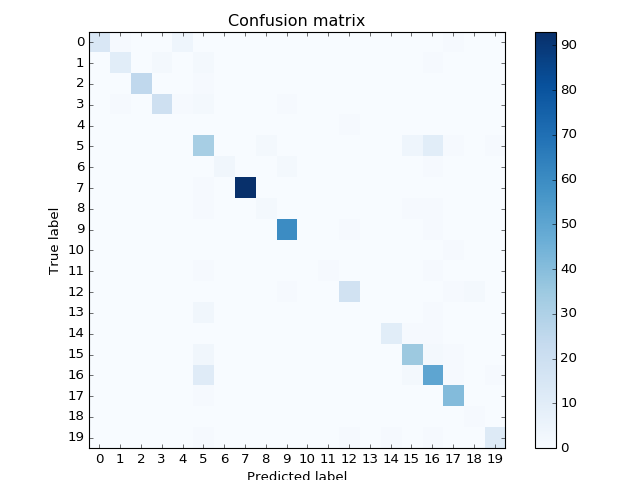

Normalized confusion matrix (Had to scale by 99 not 100 because the matrix will be too big and wrap lines)
[[69  4  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0 66  0 13  0 13  0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0 95  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0 78  4  8  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 99  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 63  0  0  3  0  0  0  0  0  0  7 19  1  0  1]
 [ 0  0  0  0  0  0 49  0  0 33  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  1  0 97  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0 39  0  0  0  0  0  0 19 19  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 95  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 99  0  0]
 [ 0  0  0  0  0 33  0  0  0  0  0 33  0  0  0  0 33  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0 81  0  0  0  0  4  9  0]
 [ 0  0  0  0  0 74  0  0  0  0  0  0  0  0  0  0 24  0  0  0]
 [ 0  0  0 

<IPython.core.display.Javascript object>


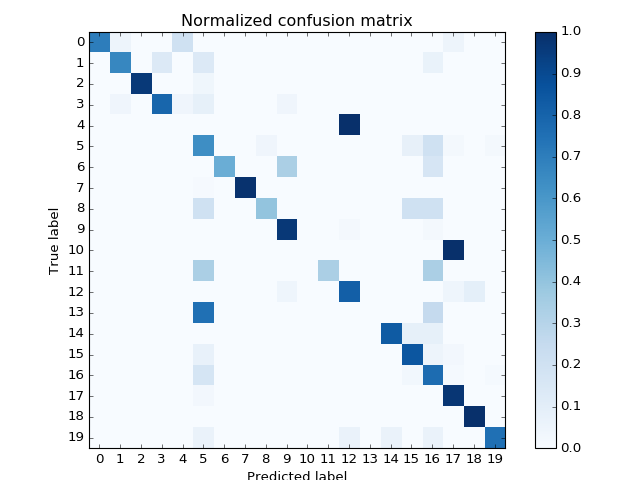

In [89]:
cm = confusion_matrix(y_true, y_pred)
print 'Confusion matrix, without normalization'
print cm
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print 'Normalized confusion matrix (Had to scale by 99 not 100 because the matrix will be too big and wrap lines)'
print (cm_normalized * 99).astype('int')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

### Classification Report
Show scoring like precision, recall, f1 and their average for each label

In [90]:
print classification_report(y_true, y_pred, target_names=None)

             precision    recall  f1-score   support

          0       1.00      0.70      0.82        20
          1       0.83      0.67      0.74        15
          2       1.00      0.96      0.98        26
          3       0.90      0.79      0.84        24
          4       0.00      0.00      0.00         1
          5       0.54      0.64      0.59        50
          6       1.00      0.50      0.67         6
          7       1.00      0.99      0.99        94
          8       0.50      0.40      0.44         5
          9       0.94      0.97      0.95        62
         10       0.00      0.00      0.00         1
         11       1.00      0.33      0.50         3
         12       0.86      0.82      0.84        22
         13       0.00      0.00      0.00         4
         14       0.91      0.83      0.87        12
         15       0.81      0.85      0.83        41
         16       0.71      0.77      0.74        65
         17       0.87      0.98      0.92   

## Learning Curves
Watch the performance of our chosen model as we increase the training size and check if it has variance or bias or somewhere in between

In [97]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-Score Weighted of CVs")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='f1_weighted',
                                                            n_jobs=n_jobs, train_sizes=train_sizes, verbose=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print 'Train scores mean:', train_scores_mean
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="%d-Fold Cross-validation score" % cv)

    plt.legend(loc="best")
    return plt

<IPython.core.display.Javascript object>


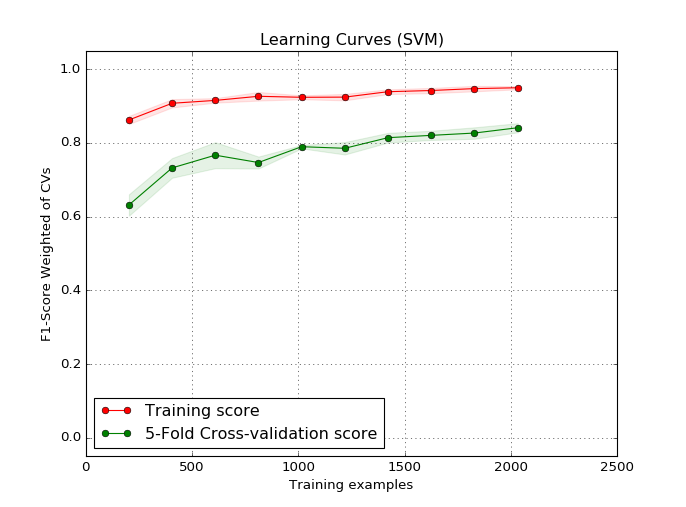

[learning_curve] Training set sizes: [ 203  406  609  812 1015 1218 1421 1624 1827 2031]
Wall time: 1min 40s


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.4min finished


In [91]:
%%time
# cv = ShuffleSplit(X_train_selected.shape[0], n_iter=5, test_size=0.2, random_state=42)
title = 'Learning Curves (%s)' % type(clf).__name__
X = vstack((X_train_final, X_test_final))
y = np.concatenate((y_train, y_test))
plot_learning_curve(clf, title, X, y, ylim=(-0.05, 1.05), cv=5, n_jobs=2)
plt.show()